In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
from Levenshtein import distance

from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
print(date)

output_dir = 'figures_' + date + '/'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

from pandarallel import pandarallel  # Speed up Pandas functions
pandarallel.initialize(progress_bar=False, nb_workers=12)

2024-06-10
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# Set parameters for Seaborn plotting
sns.set(rc = {'figure.figsize':(3,3),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1, palette='colorblind')

In [3]:
training_seqs = pd.read_csv('fully_annotated_V2_training_seqs_24-04-11.csv', index_col=0)

seq_df = pd.read_csv('RBD_1K_sequences_24-03-16.csv', index_col=0)
seq_df = seq_df[seq_df['Antigen'] == 'RBD']

### Different V gene usage by antigen

In [4]:
training_seqs['v_gene.H'] = training_seqs['v_gene.H_x'].apply(lambda x: x.split('*')[0])
training_seqs['v_gene.L'] = training_seqs['v_gene.L'].apply(lambda x: x.split('*')[0])

seq_df['v_gene.H'] = seq_df['v_gene.H'].apply(lambda x: x.split('*')[0])
seq_df['v_gene.H'] = seq_df['v_gene.H'].replace({'IGHV3-53':'IGHV3-53/66', 'IGHV3-66':'IGHV3-53/66'})
training_seqs['v_gene.H'] = training_seqs['v_gene.H'].replace({'IGHV3-53':'IGHV3-53/66', 'IGHV3-66':'IGHV3-53/66'})

In [5]:
pdf = pd.DataFrame(seq_df.groupby('Antigen')['v_gene.H'].value_counts())
pdf['VH_gene'] = pdf.index.get_level_values(1)
pdf.index = pdf.index.get_level_values(0)

pdf = pdf.pivot(columns='VH_gene').T
pdf.index = pdf.index.get_level_values(1)

pdf = pdf.divide(pdf.sum()) * 100

pdf = pdf.sort_values(by='RBD', ascending=False)

In [6]:
plot_df = seq_df[seq_df['v_gene.H'].isin(seq_df['v_gene.H'].value_counts().head(10).index)]
plot_df = plot_df[plot_df['v_gene.L'].isin(seq_df['v_gene.L'].value_counts().head(10).index)]

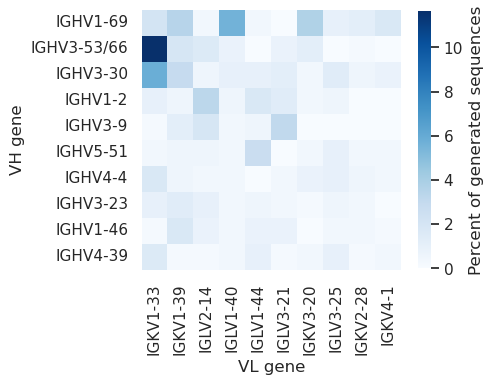

In [7]:
sns.set(rc = {'figure.figsize':(5,5),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1, palette='colorblind')

matrix = pd.crosstab(plot_df['v_gene.H'], plot_df['v_gene.L'])

matrix = (matrix / len(plot_df)) * 100
matrix = matrix[matrix.sum().sort_values(ascending=False).index]
matrix = matrix.loc[matrix.sum(axis=1).sort_values(ascending=False).index]

sns.heatmap(matrix, cmap='Blues', cbar_kws={'label': 'Percent of generated sequences', 'shrink':0.65}, square=True)

plt.xlabel('VL gene')
plt.ylabel('VH gene')

plt.tight_layout()

# plt.savefig('vh_vl_heatmap_top10_RBD_V2_24-05-27.svg')

### Mutations to training data

In [8]:
# Compare each generated VH to all training sequences to fnid the minimum distance match
# Run time: 7.8s on 12 CPU
seq_df['VH_lev'] = seq_df['VH'].parallel_apply(lambda x: training_seqs['VH_AA'].apply(lambda y: distance(x,y)).min())
seq_df['VL_lev'] = seq_df['VL'].parallel_apply(lambda x: training_seqs['VL_AA'].apply(lambda y: distance(x,y)).min())

/home/perry/miniconda3/envs/abnumber/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/perry/miniconda3/envs/abnumber/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


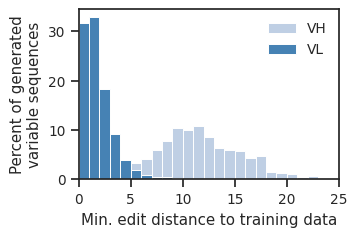

In [9]:
sns.set(rc = {'figure.figsize':(3.7,2.5),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = .9, palette='colorblind')
sns.set_style('ticks')

sns.histplot(seq_df['VH_lev'], stat='percent', binwidth=1, color='lightsteelblue', label='VH', alpha=0.8)

sns.histplot(seq_df['VL_lev'], stat='percent', binwidth=1, color='steelblue', label='VL', alpha=1)

plt.legend(frameon=False)
plt.xlabel('Min. edit distance to training data')
plt.ylabel('Percent of generated\nvariable sequences')
plt.xlim(0,25)

plt.tight_layout()

# plt.savefig('./v2_figs/percent_VH-VL_dist_V2-RBD_24-04-15.svg')

In [10]:
def lev_identity(seq1, seq2):
    lev_dist = distance(seq1, seq2)
    max_len = max(len(seq1), len(seq2))
    norm_dist = lev_dist / max_len
    norm_identity = 1 - norm_dist

    return norm_identity


seq_df['max_CDRH3_id'] = seq_df['CDR3.H'].parallel_apply(lambda x: (training_seqs['CDR3.H'].apply(lambda y: lev_identity(x,y))).max())
seq_df['max_CDRL3_id'] = seq_df['CDR3.L'].parallel_apply(lambda x: (training_seqs['CDR3.L'].apply(lambda y: lev_identity(x,y))).max())

/home/perry/miniconda3/envs/abnumber/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


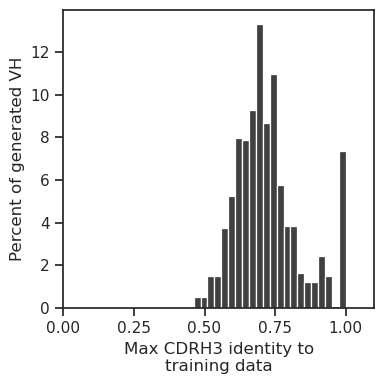

In [11]:
sns.set(rc = {'figure.figsize':(4,4),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1, palette='colorblind')
sns.set_style('ticks')


sns.histplot(seq_df['max_CDRH3_id'], stat='percent', color='black')

plt.xlim(0,1.1)
plt.xticks([0, 0.25, 0.5, 0.75, 1])

plt.xlabel('Max CDRH3 identity to\ntraining data')
plt.ylabel('Percent of generated VH')

plt.tight_layout()

# plt.savefig('CDRH3_identity_to_training_1K-CoV_24-05-27.svg')

In [12]:
seq_df['Antigen'].value_counts()

Antigen
RBD    991
Name: count, dtype: int64

/home/perry/miniconda3/envs/abnumber/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/tmp/ipykernel_1698259/3271902160.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


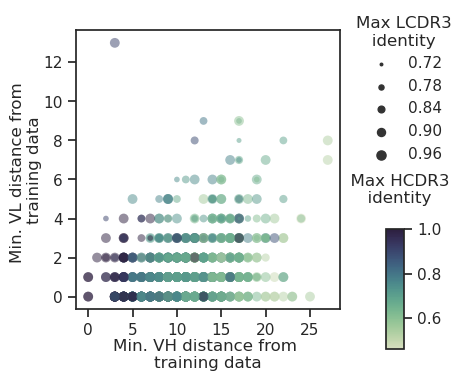

In [14]:
sns.set(rc = {'figure.figsize':(6,4),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1, palette='colorblind')
sns.set_style('ticks')


fig, ax = plt.subplots()
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

# Plotting
scatter = sns.scatterplot(data=seq_df, x='VH_lev', y='VL_lev', hue='max_CDRH3_id', alpha=0.5, size='max_CDRL3_id', sizes=(0.01, 50), palette=cmap,linewidth=0, vmin=0, vmax=1, ax=ax)    

plt.xlabel('Min. VH distance from \ntraining data', labelpad=0.8)
plt.ylabel('Min. VL distance from \ntraining data', labelpad=0.8)
plt.xticks([0,5,10,15,20,25])

# Handling legend and colorbar
h, l = ax.get_legend_handles_labels()
plt.legend(h[8:len(h)], l[8:len(l)], bbox_to_anchor = (1.01, 1.1), title='Max LCDR3\n   identity', frameon=False)
norm = plt.Normalize(seq_df['max_CDRH3_id'].min(), seq_df['max_CDRH3_id'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax.set_aspect(2.2, adjustable='box')
cbar_ax = fig.add_axes([0.77, 0.1, 0.03, 0.3], title='  Max HCDR3\n  identity\n')  # Position and size of the colorbar
fig.colorbar(sm, cax=cbar_ax)

plt.tight_layout()

In [17]:
seq_df['VH SHM'] = (1 - seq_df['v_identity.H']) * 100
seq_df['VL SHM'] = (1 - seq_df['v_identity.L']) * 100

/home/perry/miniconda3/envs/abnumber/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


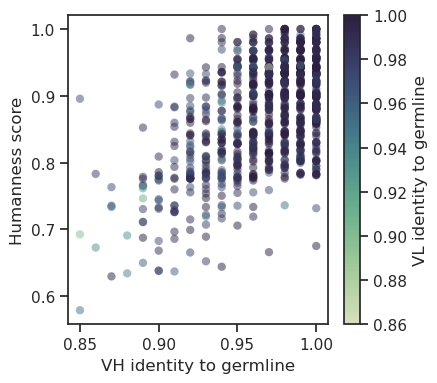

In [24]:
sns.set(rc = {'figure.figsize':(4.5,4),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1, palette='colorblind')
sns.set_style('ticks')

fig, ax = plt.subplots()
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

scatter = sns.scatterplot(data=seq_df, x='v_identity.H', y='OASis Percentile',  hue='v_identity.L', alpha=0.5,  palette=cmap,linewidth=0, vmin=0, vmax=1, legend=False)    

plt.xlabel('VH identity to germline')
plt.ylabel('Humanness score')

norm = plt.Normalize(seq_df['v_identity.L'].min(), seq_df['v_identity.L'].max())

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, ax=ax, label='VL identity to germline')

plt.tight_layout()

# plt.savefig(vh_humanness_heatmap_RBD.png', dpi=400)

/home/perry/miniconda3/envs/abnumber/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/perry/miniconda3/envs/abnumber/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


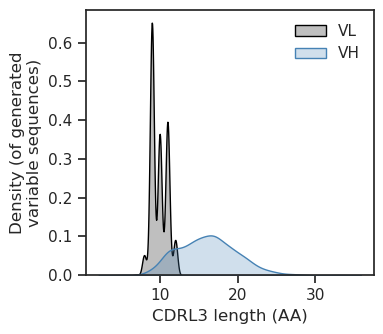

In [26]:
seq_df['CDRH3 length (AA)'] = seq_df['CDR3.H'].apply(len)
seq_df['CDRL3 length (AA)'] = seq_df['CDR3.L'].apply(len)

sns.set(rc = {'figure.figsize':(4,3.5),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1, palette='colorblind')
sns.set_style('ticks')

sns.kdeplot(seq_df['CDRL3 length (AA)'], color='black', label='VL', bw_adjust=1, common_norm=True, fill=True)
sns.kdeplot(seq_df['CDRH3 length (AA)'], color='steelblue', label='VH', bw_adjust=1, fill=True)

plt.legend(frameon=False)
plt.ylabel('Density (of generated\nvariable sequences)')

plt.tight_layout()

# plt.savefig('ext_fig2b_CDR3_length.svg')

/home/perry/miniconda3/envs/abnumber/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/perry/miniconda3/envs/abnumber/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


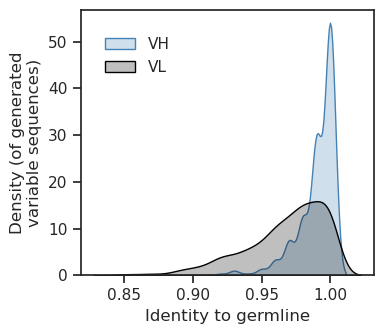

In [27]:
seq_df['CDRH3 length (AA)'] = seq_df['CDR3.H'].apply(len)
seq_df['CDRL3 length (AA)'] = seq_df['CDR3.L'].apply(len)

sns.set(rc = {'figure.figsize':(4,3.5),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1, palette='colorblind')
sns.set_style('ticks')

sns.kdeplot(seq_df['v_identity.L'], color='steelblue', label='VH', fill=True)
sns.kdeplot(seq_df['v_identity.H'], color='black', label='VL', fill=True)

plt.ylabel('Density (of generated\nvariable sequences)')
plt.xlabel('Identity to germline')

plt.legend(frameon=False, bbox_to_anchor=(0.35,0.95))

plt.tight_layout()

# plt.savefig('ext_fig2c_germline.svg')